# 4. Convolutional neural networks (CNN)

With ANNs, our first step in the MNIST analysis was to flatten the image matrix into a vector. This approach is not translation invariant: 
* a completely different set of nodes gets activated when the image is shifted.
* ignores the dependency between nearby pixels.
* requires a large number of parameters/weights aseach node in the first hidden layer is connected to all nodes in the input layer

Convolutional layers allow to handle multidimensional data, without flattening!

2d convolutional layers use 2 dimensional input (for example images) to construct 2 dimensional feature maps:
* The weights in a 2d convolutional layer are structured in a small image, called the kernel or the filter:
<img src="./imgs/cnn_1.png" alt="cnn_1" style="width: 300px;"/>

* We slide the kernel over the input image, multiply the selected part of the image and the kernel elementwise and sum:
<img src="./imgs/cnn_2.png" alt="cnn_2" style="width: 300px;"/>

In [1]:
# import libs
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from keras import backend as K

seed = 123

def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
reset_random_seeds(seed)

Using TensorFlow backend.


In [3]:
# load mnist data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
x_train = x_train/255
x_test = x_test/255

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
# expand dimension to fourth axis
x_train = tf.expand_dims(x_train, axis = -1, name=None); x_train.shape # -1 to add dimension 'on the right side'
x_test = tf.expand_dims(x_test, axis = -1, name=None); x_test.shape

TensorShape([10000, 28, 28, 1])

In [7]:
print(f'dim x_train:{x_train.shape}, dim x_test:{x_test.shape}')

dim x_train:(60000, 28, 28, 1), dim x_test:(10000, 28, 28, 1)


In [8]:
# y_train
output_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
output_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

### 4.1 Fitting a CNN

In order to fit our CNN we need to add a 2D convolutional layer:

```python
model.add(tf.keras.layers.Conv2D(filters = 8, 
                                 kernel_size = 3,
                                 strides = c(1, 1),
                                 input_shape = (28, 28, 1)))
```
* **filters = 8**: We construct 8 feature maps associated to different kernels/filters.
* **kernel_size = c(3, 3)**: The filter/kernel has a size of 3x3.
* **strides = c(1, 1)**: We move the kernel in steps of 1 pixel in both the horizontal and vertical direction. This is a common choice.
* **input_shape = (28, 28, 1)**: If this is the first layer of the model, we also have to specify the dimensions of the input data. The input consists of 1 image of size 28x28.

A convolution layer is typically followed by a pooling step, which reduces the size of feature maps. Pooling layers divide the image in blocks of equal size
and then aggregate the data per block. Two common operations are:
* average pooling
* max pooling


When all features are extracted, the data is flattened.This data can be seen as engineered features, automatically created by the CNN architecture. In a next step, a feed-forward ANN is used to analyze these local features.

In [9]:
reset_random_seeds(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.keras.backend.set_session(session_conf)

# fitting convolutional neural netword
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 8, 
                                 kernel_size = 3, 
                                 input_shape = (28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size = 2,
                                      strides = 2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 10, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'RMSprop',
              metrics = ['accuracy'])

tf.compat.v1.keras.backend.clear_session()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(x = x_train,
          y = output_train,
          epochs = 10,
          batch_size = 128,
          validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 5s 104us/sample - loss: 0.4929 - accuracy: 0.8677 - val_loss: 0.2869 - val_accuracy: 0.9162
Epoch 2/10
48000/48000 [==============================] - 5s 94us/sample - loss: 0.2859 - accuracy: 0.9169 - val_loss: 0.2582 - val_accuracy: 0.9259
Epoch 3/10
48000/48000 [==============================] - 4s 91us/sample - loss: 0.2528 - accuracy: 0.9274 - val_loss: 0.2263 - val_accuracy: 0.9366
Epoch 4/10
48000/48000 [==============================] - 4s 94us/sample - loss: 0.2254 - accuracy: 0.9355 - val_loss: 0.2027 - val_accuracy: 0.9448
Epoch 5/10
48000/48000 [==============================] - 4s 84us/sample - loss: 0.1970 - accuracy: 0.9436 - val_loss: 0.1802 - val_accuracy: 0.9518
Epoch 6/10
48000/48000 [==============================] - 4s 85us/sample - loss: 0.1720 - accuracy: 0.9508 - val_loss: 0.1629 - val_accuracy: 0.9578
Epoch 7/10
48000/48000 [==============================]

In [14]:
# evaluate performance
test_loss, test_accuracy = model.evaluate(x_test, output_test, verbose = 0)
print(f'loss:{test_loss}, accuracy:{test_accuracy}')

loss:0.11180946557745337, accuracy:0.967199981212616


In [13]:
# test reproducibility
# 10 epochs - loss:0.11180946557745337, accuracy:0.967199981212616

In [14]:
# prediction using test set
prediction = model.predict(x_test)

In [15]:
# prediction vs actual
predicted_category = np.argmax(prediction, axis = 1)
actual_category = np.argmax(output_test, axis = 1)

In [16]:
# mis-predicted values
mask = np.equal(predicted_category,actual_category)
index_mispred = np.where(~mask)

The number of mis-predicted values

In [17]:
(~mask).sum()

328

In [ ]:
# test reproducibility
# 328

In [18]:
# bulding df predicted/actual categories
df = pd.DataFrame({'pred_cat':predicted_category,
                   'actual_cat':actual_category})

In [19]:
df.head()

,pred_cat,actual_cat
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [20]:
def plot_img_3d_tensor(vector_picture, which, actual_v, predited_v):
    pixels = np.array(vector_picture)[which][:][:][:]
    plt.imshow(pixels, cmap='gray')
    plt.title(f'actual:{actual_category[which]}, predicted:{predicted_category[which]}')
    plt.show()

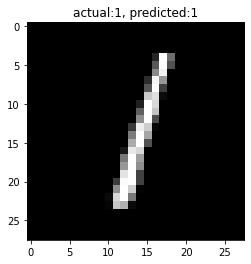

In [21]:
plot_img_3d_tensor(x_test, 2, df['actual_cat'], df['pred_cat'])

In [22]:
filters = model.get_weights()

In [23]:
model.layers

In [24]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()

In [25]:
filters[:, :, :, 0].shape

(3, 3, 1)

In [26]:
#Iterate through all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, filters.shape)

conv2d (3, 3, 1, 8)


In [27]:
#normalize filter values between 0 and 1 for visualization
f_min, f_max = weights.min(), weights.max()
filters = (weights - f_min) / (f_max - f_min)  
print(filters.shape[3])
filter_cnt=1

8


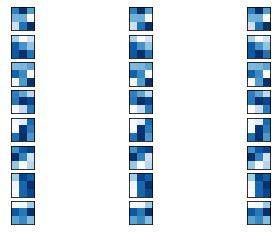

In [32]:
#plotting all the filters
filter_cnt = 1
for i in range(filters.shape[3]):
    #get the filters
    filt=filters[:,:,:,i]
    #plotting each of the channel, color image RGB channels
    for j in range(filters.shape[0]):
        ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(filt[:,:,:], cmap = 'Blues')
        filter_cnt+=1
plt.show()

In [33]:
filters[:, :, :, 0]

array([[[0.42008075],
        [0.59515166],
        [0.3518199 ]],

       [[0.29819727],
        [0.3070597 ],
        [0.02418828]],

       [[0.14303386],
        [0.45222193],
        [0.591597  ]]], dtype=float32)